In [65]:
import pandas as pd
from utils import Variable, read_values
import numpy as np
import matplotlib.pyplot as plt
values = read_values()
df = values[2023][1]
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df['open_date'] = pd.to_datetime(df['open_date'])
df = df.set_index('open_date')
df.tail()

,open_time,Open,High,Low,Close,Volume,close_time,quote_assets_volume,number_of_trades,taker_buy_base_asset_vol,taker_buy_quote_asset_vol,ignore,diff,dow
open_date,,,,,,,,,,,,,,
2023-01-31 19:00:00,1675191600000,23166.54,23188.58,23087.28,23163.88,9139.87470,1675195199999,2.115525e+08,255342,4629.58694,1.071623e+08,0,-2.66,1
2023-01-31 20:00:00,1675195200000,23162.99,23172.80,23045.07,23095.41,10546.57529,1675198799999,2.437793e+08,278257,5310.79043,1.227582e+08,0,-67.58,1
2023-01-31 21:00:00,1675198800000,23095.41,23124.34,22812.69,22948.69,17969.15727,1675202399999,4.125522e+08,415960,8897.44872,2.042856e+08,0,-146.72,1
2023-01-31 22:00:00,1675202400000,22947.66,23320.00,22872.12,23181.81,12479.54407,1675205999999,2.877016e+08,329247,6735.94740,1.553381e+08,0,234.15,1
2023-01-31 23:00:00,1675206000000,23181.81,23188.70,23081.19,23125.13,10955.34795,1675209599999,2.533282e+08,290364,5462.81000,1.263245e+08,0,-56.68,1


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   open_time                  743 non-null    int64         
 1   Open                       743 non-null    float64       
 2   High                       743 non-null    float64       
 3   Low                        743 non-null    float64       
 4   Close                      743 non-null    float64       
 5   Volume                     743 non-null    float64       
 6   close_time                 743 non-null    int64         
 7   quote_assets_volume        743 non-null    float64       
 8   number_of_trades           743 non-null    int64         
 9   taker_buy_base_asset_vol   743 non-null    float64       
 10  taker_buy_quote_asset_vol  743 non-null    float64       
 11  ignore                     743 non-null    int64         
 12  open_dat

In [66]:
import ta
#df.ta.indicators()
#help(ta.atr)


# Compute ATR (Average True Range)
df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=20).average_true_range()

# Compute RSI (Relative Strength Index)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# Compute Midprice
df['Average'] = (df['High'] + df['Low']) / 2  # Equivalent to midprice

# Compute SMA (Simple Moving Averages)
df['MA40'] = ta.trend.SMAIndicator(df['Close'], window=40).sma_indicator()
df['MA80'] = ta.trend.SMAIndicator(df['Close'], window=80).sma_indicator()
df['MA160'] = ta.trend.SMAIndicator(df['Close'], window=160).sma_indicator()

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   open_time                  743 non-null    int64         
 1   Open                       743 non-null    float64       
 2   High                       743 non-null    float64       
 3   Low                        743 non-null    float64       
 4   Close                      743 non-null    float64       
 5   Volume                     743 non-null    float64       
 6   close_time                 743 non-null    int64         
 7   quote_assets_volume        743 non-null    float64       
 8   number_of_trades           743 non-null    int64         
 9   taker_buy_base_asset_vol   743 non-null    float64       
 10  taker_buy_quote_asset_vol  743 non-null    float64       
 11  ignore                     743 non-null    int64         
 12  open_dat

In [67]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def label_trends2(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length

    for line in range(0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
    return trendcat

def label_trends(df, window_len=16, threshold=5*1e-3):
    UP_TREND = 1
    DOWN_TREND = -1
    NO_TREND = 0
    labels = [0] * len(df)
    for row_idx in range(0,  len(df)-window_len):
        open_value = df.iloc[row_idx]['Open']
        # window = df.iloc[row_idx:row_idx+window_len]
        # -window['High'] + open_value
        for nxt_row in range(row_idx, row_idx+window_len):
            current_high = df.iloc[nxt_row]['High']
            current_low = df.iloc[nxt_row]['Low']
            if current_high > open_value*(1+threshold):
                labels[row_idx] = UP_TREND
            elif current_low < open_value*(1-threshold):
                labels[row_idx] = DOWN_TREND
            else:
                labels[row_idx] = NO_TREND

    return labels

In [68]:
labels = label_trends(df, threshold=0.01)
df['target'] = labels

array([ 0,  1, -1])

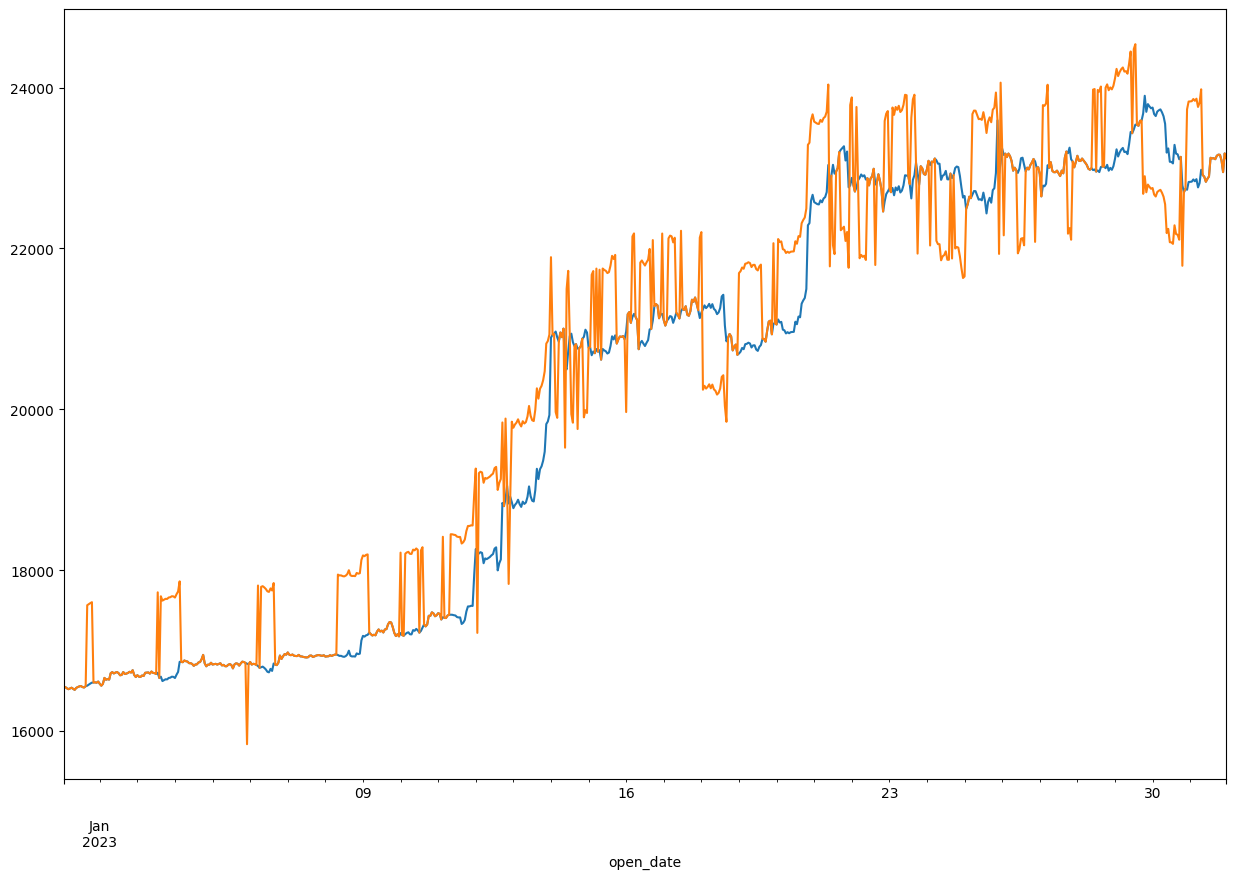

In [69]:
plt.figure(figsize=(15,10))
df['Close'].plot()
(df['target']*1000 +df['Close']).plot()
df['target'].unique()

/tmp/ipykernel_162321/1030428893.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


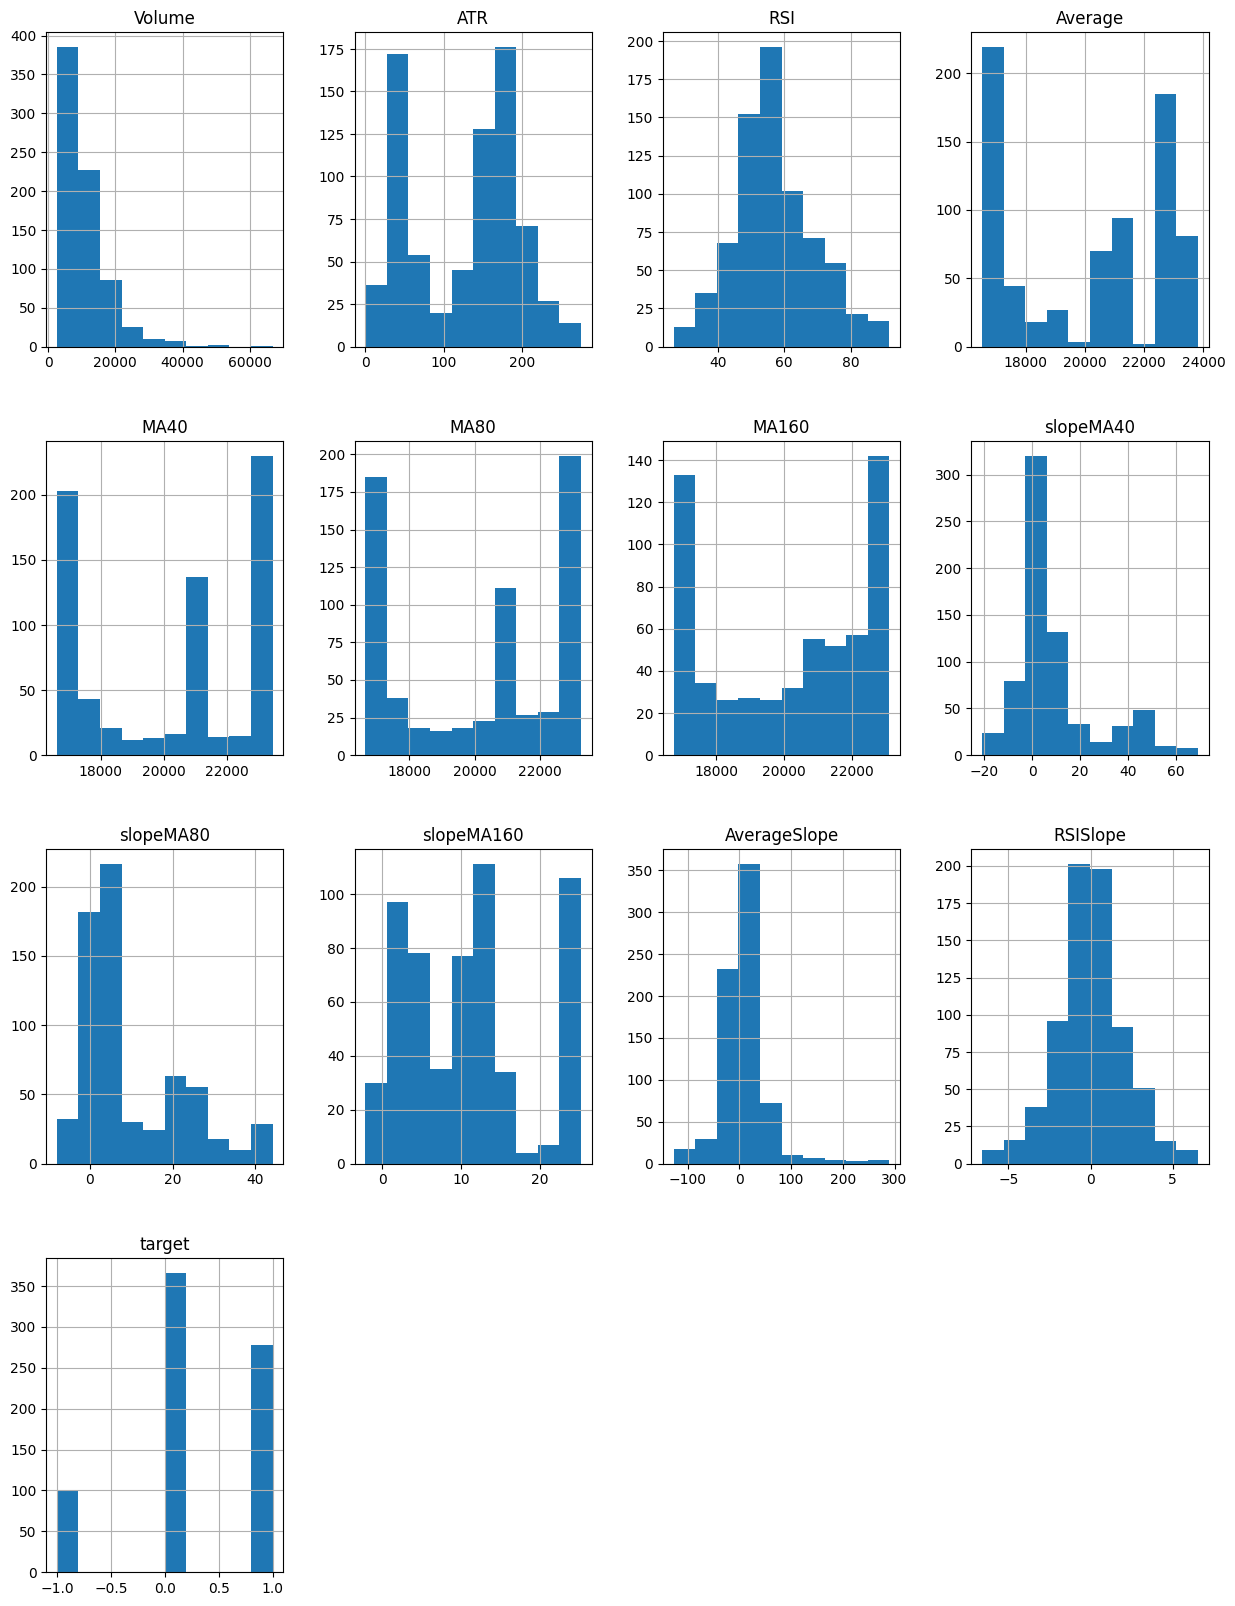

In [70]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'target']] 
df_model.hist(ax = ax)
plt.show()

In [155]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Assuming df is your DataFrame
df = df.dropna()
# Features and target
feature_columns = ['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df[['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']]
y = df['target']

# Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Train-test split for backtesting
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(solver='lbfgs', max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.44      0.14      0.22        28
           0       0.58      0.21      0.31        52
           1       0.41      1.00      0.58        36

    accuracy                           0.44       116
   macro avg       0.48      0.45      0.37       116
weighted avg       0.49      0.44      0.37       116



In [164]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from random import random
backtesting.set_bokeh_output(notebook=False)

def predict_signals(data):
    features = data[['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']].values
    return pipeline.predict(features)

# Backtesting strategy
class MLStrategy(Strategy):
    def init(self):
        self.signal = self.I(predict_signals, self.data.df)
        self.clf = pipeline
    def next(self):
        # if random() > 0.5:
        #     self.buy(size=0.01)
        # else:
        #     self.position.close()
        features = ['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
        X = self.data.df.iloc[-1:][features]
        signal = self.clf.predict(X)
        if signal == 1 and not self.position:
            self.buy(size=0.01)
        elif signal == -1 and self.position:
            self.position.close()

# Run backtest
bt = Backtest(df, MLStrategy, cash=10000000, commission=0.002)
results = bt.run()
print(results)

/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Start                     2023-01-07 21:00:00
End                       2023-01-31 23:00:00
Duration                     24 days 02:00:00
Exposure Time [%]                    77.20207
Equity Final [$]               10028217.13636
Equity Peak [$]                10029219.84124
Commissions [$]                    4655.41348
Return [%]                            0.28217
Buy & Hold Return [%]                36.51754
Return (Ann.) [%]                     4.21994
Volatility (Ann.) [%]                 0.44396
CAGR [%]                              4.36298
Sharpe Ratio                          9.50532
Sortino Ratio                        30.99219
Calmar Ratio                        100.90587
Max. Drawdown [%]                    -0.04182
Avg. Drawdown [%]                    -0.01222
Max. Drawdown Duration        4 days 11:00:00
Avg. Drawdown Duration        1 days 03:00:00
# Trades                                   13
Win Rate [%]                         69.23077
Best Trade [%]                    

In [148]:
pipeline.predict(df[['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']].values)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1